# Bicycle model
---

*Narcís Palomeras - September 2022 - Universitat de Girona (all rights reserved)*

**This project belongs to the Universitat de Girona. It is forbidden to publish this project or any derivative work in any public repository.**

---

Fill in the names of the group members:

#### Name 1
#### Name 2 (if available)

---

This lab is about kinematic motion models and basic motion controllers. It is divided in three parts:

* The Bicycle model
* Moving to a point ($x$, $y$)
* Move to a pose ($x$, $y$, $\theta$)

## Bicycle model

The bicycle model is a simplification of the popular *Ackerman* model used by cars. It is described by the following figure ([source](https://link.springer.com/book/10.1007/978-3-642-20144-8)):

<img src="http://eia.udg.edu/~npalomer/imgs/as/bicycle_model.png" width=450/>

The state of a *bicycle* is represented by:

$$
q = [x~y~\theta]
$$

where:

* $x$: is the $x$ position of the bicycle wrt. the world frame.
* $y$: is the $y$ position of the bicycle wrt. the world frame.
* $\theta$: is the orientation of the bicycle wrt. the world frame.

Because we are modelling a kinematic model, you do not have to include velocities in the state. However, let's define them:

* $v$: is the linear of the bicycle wrt. the bicycle frame.
* $w$: is the angular velocity of the bicycle, being $w = \dot{\theta}$.

The linear velocity measured in the vehicle frame is:

$$
^V{}\dot{x} = \nu, ~ ^V{}\dot{y} = 0 
$$

The bicycle model has 2 control inputs: 

* Desired velocity ($\nu_d$)
* Desired steering angle ($\gamma_d$)

## Pre-lab 


> **Exercise**: To measure the turnning speed we need to compute first the *turning radius*. Looking at the figure above, measure the *turning radius* ($R_{1}$) using only the steering angle ($\gamma$) and the wheel base ($L$). Once you know the turning radius ($R_1$) you can compute the angular velocity $\dot{\theta}$ using the turning radius $R_1$ and the forward velocity $\nu$.


> **Exercise**: Compute $\dot{\theta}$

*Notice that when $\nu=0$ then $\dot{\theta} = 0$, then it is not possible to change the vehicle’s orientation when it is not moving.*


> **Exercise**: Compute $x_{t+1}$, $y_{t+1}$ and $\theta_{t+1}$ using only $\nu$, $\dot{\theta}$ and the previous state $[x_t, y_t, \theta_t]$.


> **Exercise**: Although we are implement a kinematics model, we will set a maximum/minimum acceleration. Therefore, if we know the maximum/minimum accelerations as well as the previous velocities (ie., $\nu_{t-1}$ and $w_{t-1}$) how can we limit the change in velocity respecting the maximum/minimum accelerations? Propose an equation.

## LAB

### Auxiliar functions:

Two functions are given to you to simplify the implementation:

* `wrap_angle`: Wraps angle between -$\pi$ and $\pi$.
* `plot_results`: Plot control commands and the bicycle model state

Check the code because you will need to use it in the following sections.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def wrap_angle(angle):
    """ Wraps angle between -pi and pi 

    @type  angle: float or numpy array
    @param angle: angle in radians

    @rtype:   float or numpy array
    @return:  angle in radians between -Pi to Pi
    """
    if isinstance(angle, float) or isinstance(angle, int):
        return (angle + ( 2.0 * np.pi * np.floor( ( np.pi - angle ) / ( 2.0 * np.pi ) ) ) )
    elif isinstance(angle, np.ndarray):
        return (angle + np.pi) % (2 * np.pi ) - np.pi 
    elif isinstance(angle, list):
        ret = []
        for i in angle:
            ret.append(wrap_angle(i))
        return ret
    else:
        raise NameError('wrap_angle')

In [2]:
def plot_results(controls, states):
    """ Plot control commands and the bicycle model state
    @type  controls: list()
    @param controls: list of 2D lists containing [desired velocity, steering angle] 
    
    @type  states: list()
    @param states: list of 5D lists containing desired vehicle state [x, y, theta, v, w] 
    """

    i = np.array(controls).T
    plt.plot(i[0], label="v (m/s)")
    plt.plot(i[1], label="gamma (rad)")
    plt.title("Control commands")
    plt.legend()
    plt.show()

    p = np.array(states).T
    plt.plot(p[0], p[1], label="trajectory (m)")
    plt.plot(p[0][-1], p[1][-1], "*", label="goal")
    plt.axis('equal')
    plt.title("Trajectory")
    plt.legend()
    plt.figure(figsize=(6,6))
    plt.show()

    plt.plot(p[3], label="v (m/s)")
    plt.plot(p[4], label="w (rad/s)")
    plt.title("Velocity")
    plt.legend()
    plt.show()

### Exercise1: Implement the bicycle model kinematics

The kinematics model is able to compute the bicycle next state $q=[x~y~\theta~\nu~w]$ given the current state, the desired velocity ($\nu_d$) and the steering angle ($\gamma$) considering the maximum velocity and acceleration that the vehicle is able to reach.

```python
def bicycle_kinematics_model([x_t, y_t, theta_t, v_t, w_t], v_d, gamma_d):
    ...
    return [x, y, theta, v, w]
```


* `[x, y, theta, v, w]` is the vehicle state at time *t+1*,
* `[x_t, y_t, theta_t, v_t, w_t]` is the vehicle state at time *t* 
* `v_d` is the desired forward velocity, 
* `gamma_d` is the desired steering angle, 

The following parameters will be used

* `inc_t = 0.1` is the time increment per step,
* `L = 0.98` is the distance between the bicycle wheels,
* `max_steering = 40º` the maximum steering angle allowed (mechanically).
* `max_v = [6 m/s, 3.1416 rad/s]` the maximum velocity that the model can achieve both linear and angular.
* `min_v = [0 m/s, -3.1416 rad/s]` the minimum velocity that the model can achieve both linear and angular.
* `max_a = [2 m/s2, 1.57 rad/s2]` the maximum acceleration that the model can achieve both linear and angular.
* `min_a = [-4 m/s2, -3.1416 rad/s2]` the minimum acceleration that the model can achieve both linear and angular.

Complete the following class.

In [3]:
class BicycleModel:
    def __init__(self, initial_state=np.zeros(5), wheel_base=0.98, max_steering=0.7, max_vel=6.0, inc_t=0.1):
        """ Creates a bicycle model class 
        @type  initial_state: ndarray
        @param initial_state: ndarray containing initial [x y theta v w] 

        @type  wheel_base: float
        @param wheel_base: distance (m) between the 2 axis of the two wheels

        @type  max_vel: float
        @param max_vel: maximum velocity (m/s) that the model can reach

        @type  max_steering: float
        @param max_steering: maximum steering angle (rad) that the bicycle model can reach
        """
        self.q = initial_state  # [x, y, theta, v, w]
        self.L = wheel_base
        self.max_steering = max_steering
        self.max_vel = [max_vel, np.pi]
        self.min_vel = [0, -np.pi]
        self.max_acc = [2, np.pi/2]
        self.min_acc = [-4, -np.pi]
        self.inc_t = inc_t
       
        
    def kinematics(self, desired_v, desired_streering_angle):
        """ Computes the kinematics for a bicycle model 
        @type  desired_v: float
        @param desired_v: desired velocity command control 

        @type  desired_streering_angle: float
        @param desired_streering_angle: desired steering_angle command control

        @rtype: ndarray
        @return: ndarray containing resulting vehicle state [x y theta v w] 
        """

        if(desired_streering_angle > self.max_steering): 
            desired_streering_angle = self.max_steering
        elif(desired_streering_angle < -self.max_steering):
            desired_streering_angle = -self.max_steering
        
        linear_acceleration = (desired_v - self.q[3])/self.inc_t

        if(linear_acceleration > self.max_acc[0]):
            linear_acceleration = self.max_acc[0]
        elif(linear_acceleration < self.min_acc[0]):
            linear_acceleration = self.min_acc[0]

        linear_velocity = self.q[3] + linear_acceleration * self.inc_t

        if(linear_velocity > self.max_vel[0]):
            linear_velocity = self.max_vel[0]
        elif(linear_velocity < self.min_vel[0]):
            linear_velocity = self.min_vel[0]

        angular_velocity_desired = linear_velocity * np.tan(desired_streering_angle) / self.L
        angular_acceleration = (angular_velocity_desired - self.q[4]) / self.inc_t

        if(angular_acceleration > self.max_acc[1]):
            angular_acceleration = self.max_acc[1]
        elif(angular_acceleration < self.min_acc[1]):
            angular_acceleration = self.min_acc[1]
        
        angular_velocity = self.q[4] + angular_acceleration * self.inc_t

        if(angular_velocity > self.max_vel[1]):
            angular_velocity = self.max_vel[1]
        elif(angular_velocity < self.min_vel[1]):
            angular_velocity = self.min_vel[1]
        
        if(desired_v > self.max_vel[0]):
            desired_v = self.max_vel[0]
        elif(desired_v < self.min_vel[0]):
            desired_v = self.min_vel[0]

        v = desired_v
        w = linear_velocity * np.tan(desired_streering_angle) / self.L
        x = self.q[0] + (v ** 2) * (np.tan(desired_streering_angle) / self.L)  * (self.inc_t**2)
        y = self.q[1] + v * self.inc_t
        theta = self.q[2] + w * self.inc_t

        


        # Return new state vector
        self.q = np.array([x, y, theta, v, w])

Test the `BicycleModel` class you have just implemented by executing the following code.

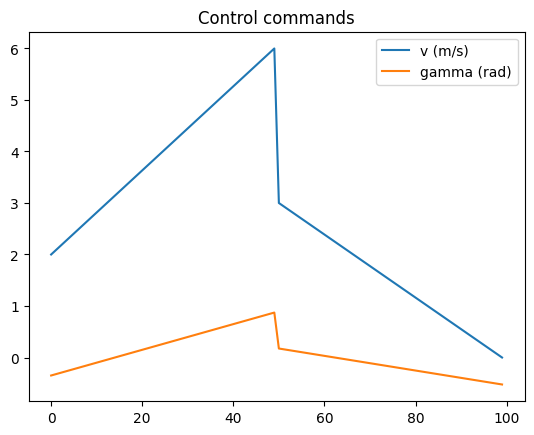

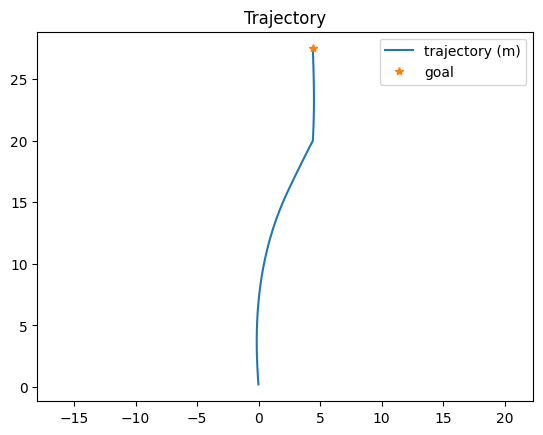

<Figure size 600x600 with 0 Axes>

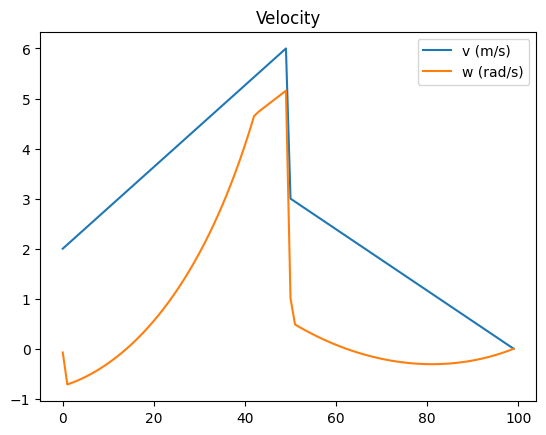

In [4]:
# Create command actions
velocity = np.hstack((np.linspace(2, 6, 50), np.linspace(3, 0, 50)))
steering = np.hstack((np.linspace(-20, 50, 50), np.linspace(10, -30, 50)))
steering = np.radians(steering)

# Create bicycle model
bike = BicycleModel()

# Execute commands using bicycle model and store the result
controls = []
states = []

for v, s in zip(velocity, steering):
    controls.append([v, s])
    bike.kinematics(v, s)
    states.append(bike.q)

plot_results(controls, states)

### Exercise 2: Move to a point controller

Now that the kinematics model for a bicycle-like vehicle is implemented, let's try to control it to move to a point ($x$, $y$).


This is a basic controller to reach a point:

$$
\nu_d = K_v \sqrt{(x_g - x)^2 + (y_g - y)}
$$

$$
\theta_d = \tan^{-1}\frac{y_g - y}{x_g - x} 
$$

$$
\gamma_d = K_h \text{wrap\_angle}(\theta_d - \theta)
$$

Where $K_v > 0$ and $K_h > 0$ and $\text{goal} = [x_g~y_g]$ 

The *move to point* controller should follow an interface similar to:

```python
def move_to_point(state, goal, Kv, Kh):
    ...
    return v_d, gamma_d
```

where:
* `state` is the current state of the robot (i.e., $[x~y~\theta~v~w]$), 
* `goal` is the $[x_g~y_g]$ position that the robot must reach
* `Kv` is a proportional gain for the forward velocity
* `Kh` is a proportional gain for the angular velocity
* `[v_d, gamma_d]` are the command actions that the controller requests to the robot to reach the `goal`.

Complete the following function:

In [5]:
def move_to_point(bike, goal, Kv=0.5, Kh=0.2):
    """ Computes the control command to move from current position to goal. 
    @type  bike: BicycleModel
    @param bike: model containing current state (q) as well as maximum velocity and steering parameters  

    @type  goal: ndarray or list
    @param goal: ndarray/list containing x, y position  

    @type  Kv: float
    @param Kv: Proportional gain for velocity contral command

    @type  Kh: float
    @param Kh: Proportional gain for steering contral command

    @rtype: float, float
    @return: Desired velocity and steering commands to reach goal from current position
    """
    
    ...

    return v_d, gamma

Test the function `move_to_point` you have implemented by executing the following code.

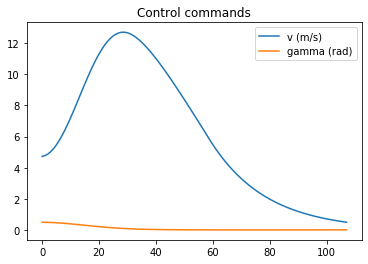

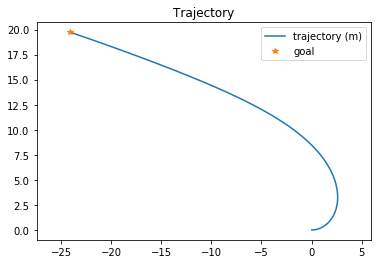

<Figure size 432x432 with 0 Axes>

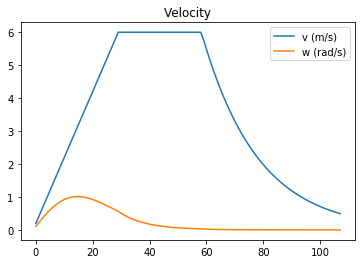

In [6]:
goal = np.array([-25.0, 20.0])
bike = BicycleModel()
max_error = 1.0

inputs = []
states = []

while np.linalg.norm(goal - bike.q[0:2]) > max_error:
    v_d, gamma = move_to_point(bike, goal)
    bike.kinematics(v_d, gamma)
    inputs.append([v_d, gamma])
    states.append(bike.q)

plot_results(inputs, states)

### Exercise 3: Move to a pose controller

For some applications it is important to have a controller that drives a vehicle not only to a point but to a pose (i.e., [$x_g$ $y_g$ $\theta_g$]). This is not always possible, but for the bicycle model there is a controller that allows to do that if the `goal` to reach is in front of the vehicle.

According to the following figure ([source](https://link.springer.com/book/10.1007/978-3-642-20144-8))

<img src="http://eia.udg.edu/~npalomer/imgs/as/bicycle_model2.png" width=450/>

the bicycle model can be represented using polar coordinates as follows:

$$
\rho = \sqrt{\Delta_x ^2 + \Delta_y ^2}
$$
$$
\alpha = \tan^{-1}\frac{\Delta_y}{\Delta_x} - \theta
$$
$$
\beta = \theta_g - \theta - \alpha
$$

being:

* `goal`: $[x_g~y_g~\theta_g$],
* vehicle `state`: $[x~y~\theta]$,
* $\Delta_x$ = $x_g - x$
* $\Delta_y$ = $y_g - y$
* $\rho$ the distance from the vehicle to the `goal`,
* $\beta$ the angle of the goal vector with respect to the world frame, and
* $\alpha$ the angle of the goal vector with respect to the vehicle frame. 

The following linear control law is able to drive the robot to a unique equilibrium point (see the demonstration [here](https://link.springer.com/book/10.1007/978-3-642-20144-8)):

$$
\nu_d = k_\rho \rho
$$

$$
\gamma_d = k_\alpha \alpha + k_\beta \beta
$$

if the following conditions hold:

$
-\pi/2 < \alpha < \pi/2 
$

and 

$
k_\rho > 0,~ k_\beta < 0,~ k_\alpha - k_\rho > 0
$

Complete the following function to implement the proposed pose controller:

In [7]:
def move_to_pose(bike, goal, Kp=0.5, Ka=1.0, Kb=-0.5): 
    """ Computes the control command to move from current position to goal pose. 
    @type  bike: BicycleModel
    @param bike: model containing current state (q) as well as maximum velocity and steering parameters  

    @type  goal: ndarray or list
    @param goal: ndarray/list containing x, y, theta pose  

    @type  Kp: float
    @param Kp: Proportional gain for velocity contral command, Kp > 0

    @type  Ka: float
    @param Ka: Proportional gain for steering contral command, Ka - Kp > 0

    @type  Kb: float
    @param Kb: Proportional gain for steering contral command, Kb < 0

    @rtype: float, float
    @return: Desired velocity and steering commands to reach the goal
    """
    
    ...

    return v_d, gamma


Goal pose reached at (25.11, 20.22), -91.0º


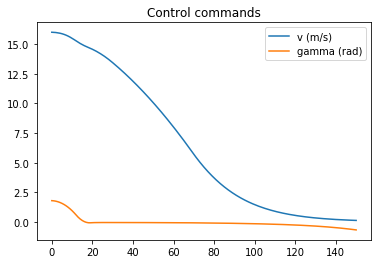

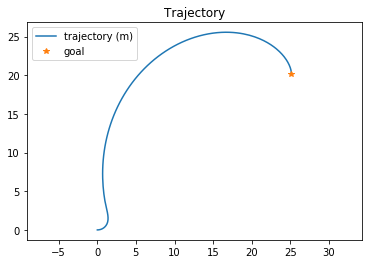

<Figure size 432x432 with 0 Axes>

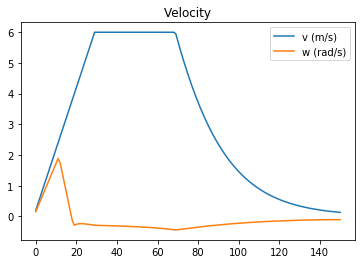

In [8]:
goal = np.array([25.0, 20.0, -np.pi/2])
bike = BicycleModel()
max_error = 0.25

inputs = []
states = []
v_d = 0

while np.linalg.norm(goal[0:2] - bike.q[0:2]) > max_error and v_d >= 0:
    v_d, gamma = move_to_pose(bike, goal)
    bike.kinematics(v_d, gamma)
    inputs.append([v_d, gamma])
    states.append(bike.q)

print("Goal pose reached at ({}, {}), {}º".format(np.round(bike.q[0],2), np.round(bike.q[1],2), np.round(np.degrees(bike.q[2])),2))
plot_results(inputs, states)

## Deliverable

Upload this Python Interactive Notebook fully completed through the Moodel platform before the deadline.
You can submit this lab up to 7 days late. However, you will be deducted 1 point if you submit it from 1 minute to 23h 59 minutes late, 2 points if you submit it from 24h to 47h 59 minutes late, etc.

Make sure that all cells can be executed.